In [1]:
from data import Dataset
from pathlib import Path
import pandas as pd
from preprocess import concatenate_video_audio, mfcc_timestamp_average
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Input, LSTM
from keras.preprocessing import sequence

In [3]:
def load_concatenated_aud_vid(
    file_path: Path, feature_type: str, delimeter: str
): #-> Dict[str, Dict[str, pd.DataFrame]]:
    """TODO"""
    if not Path.exists(file_path):
        print("Directory does not exist. Check input feature directory")
    # loaded_features: Dict = {}
    loaded_features = {}
    generator = (file_path).glob("*")
    for path in generator:
        str_path = str(path)
        start = str_path.rindex("\\")
        end = str_path.rindex("_")
        participant_id = str_path[start + 1 : end]
        full_path = path / ("features/" + participant_id + feature_type)
        participant_id_df = pd.read_csv(full_path, sep=delimeter)
        participant_id_df.columns = participant_id_df.columns.str.replace(" ", "")
        loaded_features[participant_id] = participant_id_df
    if not loaded_features:
        print(
            "No samples loaded, check the samples are available in the input directory."
        )
    return loaded_features

In [8]:
daic_path = Path("daic_dataset")
processed_storage = "daic_processed_1"
daic_processed_path = Path(processed_storage)

In [9]:
DAIC = Dataset(daic_path)

In [ ]:
# averaged_mfcc = mfcc_timestamp_average(
#     DAIC.daic_mfcc_features,
#     DAIC.daic_openface_features,
#     processed_storage,
# )

Next: Concatenate the two features. Pad them to have a consistent length and then use the sequences as inputs for the regression network. Makesure to normalise all the variables before putting them into a network

In [6]:
## find the longest sequence of video frames
longest = 0
for subset, subjects in DAIC.daic_openface_features.items():
    for subject_id, subject_df in subjects.items():
        length = subject_df.shape[0]
        if length > longest:
            longest = length
print(longest)
print(subset)
print(subject_id)

108830
test
718


In [ ]:
### Concatenate the features:
# import pandas as pd
# # print(DAIC.daic_mfcc_features["dev"]["300"].loc[0])
# # print(DAIC.daic_openface_features["dev"]["300"].loc[0])
# frames = [DAIC.daic_openface_features["dev"]["300"].loc[:10],DAIC.daic_mfcc_features["dev"]["300"].loc[:10]]
# new_line = pd.concat(frames, axis =1)
# print(new_line)
# daic_audio_video = concatenate_video_audio(averaged_mfcc[0], averaged_mfcc[1])

In [8]:
openface_train = DAIC.load_processed_openface("train")
openface_dev = DAIC.load_processed_openface("dev")
openface_test = DAIC.load_processed_openface("test")
mfcc_train = DAIC.load_processed_mfcc("train")
mfcc_dev = DAIC.load_processed_mfcc("dev")
mfcc_test = DAIC.load_processed_mfcc("test")

In [9]:
del DAIC
daic_audio_video_train = concatenate_video_audio(openface_train, mfcc_train)
daic_audio_video_dev = concatenate_video_audio(openface_dev, mfcc_dev)
daic_audio_video_test = concatenate_video_audio(openface_test, mfcc_test)
del openface_train, mfcc_train, openface_dev, mfcc_dev

In [ ]:
for subject_id, subject_df in daic_audio_video_dev.items():
    last = subject_df.shape[0] - 1
    subject_df.drop(last, inplace=True)
    Path("daic_processed_1/concat_vid_aud/dev/"
            + subject_id
            + "_P/features"
        ).mkdir(parents=True, exist_ok=True)
    subject_df.to_csv(
        "daic_processed_1/concat_vid_aud/dev/"
        + subject_id
        + "_P/features/"
        + subject_id
        + "_Concat_openface_mfcc.csv",
        index=False,
        sep=",",
    )

In [ ]:
for subject_id, subject_df in daic_audio_video_train.items():
    last = subject_df.shape[0] - 1
    subject_df.drop(last, inplace=True)
    Path("daic_processed_1/concat_vid_aud/train/"
            + subject_id
            + "_P/features"
        ).mkdir(parents=True, exist_ok=True)
    subject_df.to_csv(
        "daic_processed_1/concat_vid_aud/train/"
        + subject_id
        + "_P/features/"
        + subject_id
        + "_Concat_openface_mfcc.csv",
        index=False,
        sep=",",
    )

In [10]:
for subject_id, subject_df in daic_audio_video_test.items():
    last = subject_df.shape[0] - 1
    subject_df.drop(last, inplace=True)
    Path("daic_processed_1/concat_vid_aud/test/"
            + subject_id
            + "_P/features"
        ).mkdir(parents=True, exist_ok=True)
    subject_df.to_csv(
        "daic_processed_1/concat_vid_aud/test/"
        + subject_id
        + "_P/features/"
        + subject_id
        + "_Concat_openface_mfcc.csv",
        index=False,
        sep=",",
    )

In [4]:
# directly load saved (combined) audio video csv files
daic_audio_video_train = load_concatenated_aud_vid(Path("daic_processed_1/concat_vid_aud/train/"), "_Concat_openface_mfcc.csv", ",")
daic_audio_video_dev = load_concatenated_aud_vid(Path("daic_processed_1/concat_vid_aud/dev/"), "_Concat_openface_mfcc.csv", ",")
daic_audio_video_test = load_concatenated_aud_vid(Path("daic_processed_1/concat_vid_aud/test/"), "_Concat_openface_mfcc.csv", ",")

In [5]:
for subject_id, subject_df in daic_audio_video_train.items():
    subject_df.drop(columns=["frame", "timestamp", "confidence", "success", "AU01_c", "AU02_c", "AU04_c", "AU05_c", "AU06_c", "AU07_c", "AU09_c", "AU10_c", "AU12_c", "AU14_c", "AU15_c", "AU17_c", "AU20_c", "AU23_c", "AU25_c", "AU26_c", "AU28_c", "AU45_c"], inplace=True)
for subject_id, subject_df in daic_audio_video_dev.items():
    subject_df.drop(columns=["frame", "timestamp", "confidence", "success", "AU01_c", "AU02_c", "AU04_c", "AU05_c", "AU06_c", "AU07_c", "AU09_c", "AU10_c", "AU12_c", "AU14_c", "AU15_c", "AU17_c", "AU20_c", "AU23_c", "AU25_c", "AU26_c", "AU28_c", "AU45_c"], inplace=True)
for subject_id, subject_df in daic_audio_video_test.items():
    subject_df.drop(columns=["frame", "timestamp", "confidence", "success", "AU01_c", "AU02_c", "AU04_c", "AU05_c", "AU06_c", "AU07_c", "AU09_c", "AU10_c", "AU12_c", "AU14_c", "AU15_c", "AU17_c", "AU20_c", "AU23_c", "AU25_c", "AU26_c", "AU28_c", "AU45_c"], inplace=True)

In [7]:
import pandas as pd
label_path = Path("daic_dataset/daic_labels")
loaded_labels = {
    "dev": {}, 
    "train": {}, 
    "test": {},
    }
paths = {
    "dev": label_path / "dev_split.csv",
    "train": label_path / "train_split.csv",
    "test": label_path / "test_split.csv",
}
for subset, path in paths.items():
    subset_df = pd.read_csv(path)
    subset_dict = subset_df.to_dict()
    for i in range(len(subset_dict["Participant_ID"])):
        participant = str(subset_dict["Participant_ID"][i])
        loaded_labels[subset][participant] = {
            "PHQ_Binary": subset_dict["PHQ_Binary"][i],
            "PHQ_Score": subset_dict["PHQ_Score"][i],
        }

In [35]:
# from sklearn import preprocessing
# import pandas as pd

# normalised_dev = {}
# for subject_id, subject_df in daic_audio_video_dev.items():
#     d = preprocessing.normalize(subject_df, axis=0)
#     scaled_df = pd.DataFrame(d, columns=daic_audio_video_dev[subject_id].columns)
#     normalised_dev[subject_id] = scaled_df
# normalised_train = {}
# for subject_id, subject_df in daic_audio_video_train.items():
#     d = preprocessing.normalize(subject_df, axis=0)
#     scaled_df = pd.DataFrame(d, columns=daic_audio_video_train[subject_id].columns)
#     normalised_train[subject_id] = scaled_df
# for subject_id, subject_df in daic_audio_video_test.items():
#     d = preprocessing.normalize(subject_df, axis=0)
#     scaled_df = pd.DataFrame(d, columns=daic_audio_video_test[subject_id].columns)
#     normalised_train[subject_id] = scaled_df
# del d

In [66]:
print(daic_audio_video_dev["300"].shape[0])
print(daic_audio_video_dev["300"].columns[0])
print(daic_audio_video_dev["300"].iloc[0]["pose_Tx"])

19455
pose_Tx
69.5


In [21]:
print(daic_audio_video_dev["300"].iloc[:]["pose_Tx"].max())

200.7


In [8]:
all_data = [daic_audio_video_train, daic_audio_video_dev, daic_audio_video_test]
def find_min_max():
    """Finds the minimum and maximum values of all feature for normalisation."""
    # only for openface features at the moment

    # !!As of now this doesn't work correctly!!
    # LEAVE THIS TO DO AFTER PREPROCESSING, some of feature values for success == 0 are ridiculous and will most likely need to be zeroed
    min_max = {
        "min": {
            "pose_Tx": 1000,
            "pose_Ty": 1000,
            "pose_Tz": 1000,
            "pose_Rx": 1000,
            "pose_Ry": 1000,
            "pose_Rz": 1000,
            "gaze_0_x": 1000,
            "gaze_0_y": 1000,
            "gaze_0_z": 1000,
            "gaze_1_x": 1000,
            "gaze_1_y": 1000,
            "gaze_1_z": 1000,
            "gaze_angle_x": 1000,
            "gaze_angle_y": 1000,
            "AU01_r": 1000,
            "AU02_r": 1000,
            "AU04_r": 1000,
            "AU05_r": 1000,
            "AU06_r": 1000,
            "AU07_r": 1000,
            "AU09_r": 1000,
            "AU10_r": 1000,
            "AU12_r": 1000,
            "AU14_r": 1000,
            "AU15_r": 1000,
            "AU17_r": 1000,
            "AU20_r": 1000,
            "AU23_r": 1000,
            "AU25_r": 1000,
            "AU26_r": 1000,
            "AU45_r": 1000,
            "pcm_fftMag_mfcc[0]": 1000,
            "pcm_fftMag_mfcc[1]": 1000,
            "pcm_fftMag_mfcc[2]": 1000,
            "pcm_fftMag_mfcc[3]": 1000,
            "pcm_fftMag_mfcc[4]": 1000,
            "pcm_fftMag_mfcc[5]": 1000,
            "pcm_fftMag_mfcc[6]": 1000,
            "pcm_fftMag_mfcc[7]": 1000,
            "pcm_fftMag_mfcc[8]": 1000,
            "pcm_fftMag_mfcc[9]": 1000,
            "pcm_fftMag_mfcc[10]": 1000,
            "pcm_fftMag_mfcc[11]": 1000,
            "pcm_fftMag_mfcc[12]": 1000,
            "pcm_fftMag_mfcc_de[0]": 1000,
            "pcm_fftMag_mfcc_de[1]": 1000,
            "pcm_fftMag_mfcc_de[2]": 1000,
            "pcm_fftMag_mfcc_de[3]": 1000,
            "pcm_fftMag_mfcc_de[4]": 1000,
            "pcm_fftMag_mfcc_de[5]": 1000,
            "pcm_fftMag_mfcc_de[6]": 1000,
            "pcm_fftMag_mfcc_de[7]": 1000,
            "pcm_fftMag_mfcc_de[8]": 1000,
            "pcm_fftMag_mfcc_de[9]": 1000,
            "pcm_fftMag_mfcc_de[10]": 1000,
            "pcm_fftMag_mfcc_de[11]": 1000,
            "pcm_fftMag_mfcc_de[12]": 1000,
            "pcm_fftMag_mfcc_de_de[0]": 1000,
            "pcm_fftMag_mfcc_de_de[1]": 1000,
            "pcm_fftMag_mfcc_de_de[2]": 1000,
            "pcm_fftMag_mfcc_de_de[3]": 1000,
            "pcm_fftMag_mfcc_de_de[4]": 1000,
            "pcm_fftMag_mfcc_de_de[5]": 1000,
            "pcm_fftMag_mfcc_de_de[6]": 1000,
            "pcm_fftMag_mfcc_de_de[7]": 1000,
            "pcm_fftMag_mfcc_de_de[8]": 1000,
            "pcm_fftMag_mfcc_de_de[9]": 1000,
            "pcm_fftMag_mfcc_de_de[10]": 1000,
            "pcm_fftMag_mfcc_de_de[11]": 1000,
            "pcm_fftMag_mfcc_de_de[12]": 1000,
        },
        "max": {
            "pose_Tx": 0,
            "pose_Ty": 0,
            "pose_Tz": 0,
            "pose_Rx": 0,
            "pose_Ry": 0,
            "pose_Rz": 0,
            "gaze_0_x": 0,
            "gaze_0_y": 0,
            "gaze_0_z": 0,
            "gaze_1_x": 0,
            "gaze_1_y": 0,
            "gaze_1_z": 0,
            "gaze_angle_x": 0,
            "gaze_angle_y": 0,
            "AU01_r": 0,
            "AU02_r": 0,
            "AU04_r": 0,
            "AU05_r": 0,
            "AU06_r": 0,
            "AU07_r": 0,
            "AU09_r": 0,
            "AU10_r": 0,
            "AU12_r": 0,
            "AU14_r": 0,
            "AU15_r": 0,
            "AU17_r": 0,
            "AU20_r": 0,
            "AU23_r": 0,
            "AU25_r": 0,
            "AU26_r": 0,
            "AU45_r": 0,
            "pcm_fftMag_mfcc[0]": -1000,
            "pcm_fftMag_mfcc[1]": -1000,
            "pcm_fftMag_mfcc[2]": -1000,
            "pcm_fftMag_mfcc[3]": -1000,
            "pcm_fftMag_mfcc[4]": -1000,
            "pcm_fftMag_mfcc[5]": -1000,
            "pcm_fftMag_mfcc[6]": -1000,
            "pcm_fftMag_mfcc[7]": -1000,
            "pcm_fftMag_mfcc[8]": -1000,
            "pcm_fftMag_mfcc[9]": -1000,
            "pcm_fftMag_mfcc[10]": -1000,
            "pcm_fftMag_mfcc[11]": -1000,
            "pcm_fftMag_mfcc[12]": -1000,
            "pcm_fftMag_mfcc_de[0]": -1000,
            "pcm_fftMag_mfcc_de[1]": -1000,
            "pcm_fftMag_mfcc_de[2]": -1000,
            "pcm_fftMag_mfcc_de[3]": -1000,
            "pcm_fftMag_mfcc_de[4]": -1000,
            "pcm_fftMag_mfcc_de[5]": -1000,
            "pcm_fftMag_mfcc_de[6]": -1000,
            "pcm_fftMag_mfcc_de[7]": -1000,
            "pcm_fftMag_mfcc_de[8]": -1000,
            "pcm_fftMag_mfcc_de[9]": -1000,
            "pcm_fftMag_mfcc_de[10]": -1000,
            "pcm_fftMag_mfcc_de[11]": -1000,
            "pcm_fftMag_mfcc_de[12]": -1000,
            "pcm_fftMag_mfcc_de_de[0]": -1000,
            "pcm_fftMag_mfcc_de_de[1]": -1000,
            "pcm_fftMag_mfcc_de_de[2]": -1000,
            "pcm_fftMag_mfcc_de_de[3]": -1000,
            "pcm_fftMag_mfcc_de_de[4]": -1000,
            "pcm_fftMag_mfcc_de_de[5]": -1000,
            "pcm_fftMag_mfcc_de_de[6]": -1000,
            "pcm_fftMag_mfcc_de_de[7]": -1000,
            "pcm_fftMag_mfcc_de_de[8]": -1000,
            "pcm_fftMag_mfcc_de_de[9]": -1000,
            "pcm_fftMag_mfcc_de_de[10]": -1000,
            "pcm_fftMag_mfcc_de_de[11]": -1000,
            "pcm_fftMag_mfcc_de_de[12]": -1000,
        },
    }
    for subset in all_data:
        for subject_id, subject_df in subset.items():
            # for subject, dataframe in subjects.items():
            for feature, _ in min_max["min"].items():
                min_value = subject_df.iloc[:][feature].min()
                max_value = subject_df.iloc[:][feature].max()
                # if min_value < -1000:
                #     print(subject_id)
                # if max_value > 1000:
                #     print(subject_id)
                if min_value < min_max["min"][feature]:
                    min_max["min"][feature] = min_value
                if max_value > min_max["max"][feature]:
                    min_max["max"][feature] = max_value
    return min_max
min_max_values = find_min_max()
print(min_max_values)

{'min': {'pose_Tx': -16093360.0, 'pose_Ty': -12070020.0, 'pose_Tz': -862953.0, 'pose_Rx': -3.14, 'pose_Ry': -1.545, 'pose_Rz': -3.14, 'gaze_0_x': -0.966169, 'gaze_0_y': -0.8422850000000001, 'gaze_0_z': -1.0, 'gaze_1_x': -0.999247, 'gaze_1_y': -0.956851, 'gaze_1_z': -1.0, 'gaze_angle_x': -2.75, 'gaze_angle_y': -2.907, 'AU01_r': 0.0, 'AU02_r': 0.0, 'AU04_r': 0.0, 'AU05_r': 0.0, 'AU06_r': 0.0, 'AU07_r': 0.0, 'AU09_r': 0.0, 'AU10_r': 0.0, 'AU12_r': 0.0, 'AU14_r': 0.0, 'AU15_r': 0.0, 'AU17_r': 0.0, 'AU20_r': 0.0, 'AU23_r': 0.0, 'AU25_r': 0.0, 'AU26_r': 0.0, 'AU45_r': 0.0, 'pcm_fftMag_mfcc[0]': -64.30880333333333, 'pcm_fftMag_mfcc[1]': -75.36926666666666, 'pcm_fftMag_mfcc[2]': -72.80992, 'pcm_fftMag_mfcc[3]': -105.50703333333333, 'pcm_fftMag_mfcc[4]': -87.74750333333333, 'pcm_fftMag_mfcc[5]': -95.27321, 'pcm_fftMag_mfcc[6]': -92.38517333333334, 'pcm_fftMag_mfcc[7]': -87.40111, 'pcm_fftMag_mfcc[8]': -86.17633666666666, 'pcm_fftMag_mfcc[9]': -89.32121999999998, 'pcm_fftMag_mfcc[10]': -75.73725

In [23]:
print(min_max_values["min"]["pose_Tx"])
min_max_df = pd.DataFrame.from_dict(min_max_values, orient="index")
print(min_max_df.loc["max"]-min_max_df.loc["min"])

-16093360.0
pose_Tx                      5.653262e+07
pose_Ty                      1.379555e+08
pose_Tz                      2.408253e+08
pose_Rx                      6.277000e+00
pose_Ry                      3.107000e+00
                                 ...     
pcm_fftMag_mfcc_de_de[8]     1.817437e+01
pcm_fftMag_mfcc_de_de[9]     1.592745e+01
pcm_fftMag_mfcc_de_de[10]    1.648379e+01
pcm_fftMag_mfcc_de_de[11]    1.443050e+01
pcm_fftMag_mfcc_de_de[12]    2.151065e+01
Length: 70, dtype: float64


In [ ]:
# all_data = [daic_audio_video_train, daic_audio_video_dev, daic_audio_video_test]
# min_values = daic_audio_video_dev["300"].iloc[0].copy()
# max_values = daic_audio_video_dev["300"].iloc[0].copy()
# # max_values.at["pose_Tx"] = 10
# # print(max_values)
# for subset in all_data:
#     for subject_id, subject_df in subset.items():
#         print(subject_id)
#         for row in range(subject_df.shape[0]):
#             for column in subject_df.columns:
#                 new_value = subject_df.iloc[row][column]
#                 current_min_value = min_values.iloc[:][column]
#                 current_max_value = max_values.iloc[:][column]
#                 if new_value < current_min_value:
#                     min_values.at[column] = new_value
#                 elif new_value > current_max_value:
#                     max_values.at[column] = new_value
#                 else:
#                     continue


In [27]:
normalised_dev = daic_audio_video_dev.copy()
normalised_test = daic_audio_video_test.copy()
normalised_train = daic_audio_video_train.copy()
all_data = [normalised_dev, normalised_test, normalised_train]
for subset in all_data:
    for subject_id, subject_df in subset.items():
        print(subject_id)
        for row in range(subject_df.shape[0]):
            values = subject_df.iloc[row]
            normalised_values = (values-min_max_df.loc["min"])/(min_max_df.loc["max"]-min_max_df.loc["min"])
            subject_df.iloc[row] = normalised_values

300
301
306
317
320
321
331
334
336
343
344
347
350
365
371
373
374
381
382
388
393
401
402
408
412
415
423
425
431
433
435
437
441
442
448
451
454
455
465
468
473
475
479
480
484
486
617
627
632
653
657
667
670
687
698
713
600
602
604
605
606
607
609
615
618
619
620
622
623
624
625
626
629
631
634
635
636
637
638
640
649
650
651
652
655
656
658
659
661
663
664
666
669
676
679
682
683
688
689
691
693
696
699
705
708
709
710
712
715
716
717
718
302
303
304
305
307
308
309
310
311
312
313
314
315
316
318
319
322
323
324
325
326
327
328
329
330
332
333
335
337
338
339
340
341
345
346
348
349
351
352
353
354
355
356
357
358
359
360
361
362
363
364
366
367
368
369
370
372
375
376
377
378
379
380
383
384
385
386
387
389
390
391
392
395
396
397
399
400
403
404
405
406
407
409
410
411
413
414
416
417
418
419
420
421
422
424
426
427
428
429
430
432
434
436
438
439
440
443
444
445
446
447
449
450
452
453
456
457
458
459
461
462
463
464
466
467
469
470
471
472
474
476
477
478
481
482
483
485
487


In [30]:
dev_test_train = ["dev", "test", "train"]
for subset, subset_label in zip(all_data, dev_test_train):
    for subject_id, subject_df in subset.items():
        Path("daic_processed_1/normalised_concat_vid_aud/"
                + subset_label + "/"
                + subject_id
                + "_P/features"
            ).mkdir(parents=True, exist_ok=True)
        subject_df.to_csv(
            "daic_processed_1/normalised_concat_vid_aud/"
            + subset_label + "/"
            + subject_id
            + "_P/features/"
            + subject_id
            + "_normalised_openface_mfcc.csv",
            index=False,
            sep=",",
        )

In [42]:
from sklearn import preprocessing
import pandas as pd

normalised_dev = {}
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(daic_audio_video_dev["300"])
for subject_id, subject_df in daic_audio_video_dev.items():
    # d = preprocessing.normalize(subject_df, axis=0)
    scaled_df = pd.DataFrame(d, columns=daic_audio_video_dev[subject_id].columns)
    normalised_dev[subject_id] = scaled_df
normalised_train = {}
for subject_id, subject_df in daic_audio_video_train.items():
    # d = preprocessing.normalize(subject_df, axis=0)
    scaled_df = pd.DataFrame(d, columns=daic_audio_video_train[subject_id].columns)
    normalised_train[subject_id] = scaled_df
normalised_test = {}
for subject_id, subject_df in daic_audio_video_test.items():
    # d = preprocessing.normalize(subject_df, axis=0)
    scaled_df = pd.DataFrame(d, columns=daic_audio_video_test[subject_id].columns)
    normalised_test[subject_id] = scaled_df
# del d

TypeError: MinMaxScaler.__init__() got an unexpected keyword argument 'axis'

In [ ]:
window_size = 400
X_dev = []
Y_dev = []
dev_samples_subject = []
for subject_id, subject_df in normalised_dev.items():
    last_frame = subject_df.shape[0]
    for i in range(window_size, last_frame, window_size):
        X_dev.append(subject_df.loc[i-window_size:i-1].to_numpy())
        Y_dev.append(loaded_labels["dev"][subject_id]["PHQ_Score"]/27)
        dev_samples_subject.append(subject_id)
X_train = []
Y_train = []
train_samples_subject = []
for subject_id, subject_df in normalised_train.items():
    last_frame = subject_df.shape[0]
    for i in range(window_size, last_frame, window_size):
        X_train.append(subject_df.loc[i-window_size:i-1].to_numpy())
        Y_train.append(loaded_labels["train"][subject_id]["PHQ_Score"]/27)
        train_samples_subject.append(subject_id)
X_test = []
Y_test = []
test_samples_subject = []
for subject_id, subject_df in normalised_test.items():
    last_frame = subject_df.shape[0]
    for i in range(window_size, last_frame, window_size):
        X_test.append(subject_df.loc[i-window_size:i-1].to_numpy())
        Y_test.append(loaded_labels["test"][subject_id]["PHQ_Score"]/27)
        test_samples_subject.append(subject_id)
del daic_audio_video_dev, daic_audio_video_train, daic_audio_video_test


In [ ]:
import numpy as np
X_dev_np = np.array(X_dev)
X_train_np = np.array(X_train)
Y_dev_np = np.array(Y_dev)
Y_train_np = np.array(Y_train)
# print(X_dev_np.shape)

In [154]:
model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# model.add(Input())
model.add(LSTM(500, activation="tanh", recurrent_activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(500, activation="tanh", recurrent_activation="relu"))
model.add(Dropout(0.2))
# model.add(LSTM(500))
# model.add(Dense(100, activation="relu"))
model.add(Dense(1, activation="relu"))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
# print(model.summary())

In [155]:
model.fit(X_train_np[:], Y_train_np[:], validation_data=(X_dev_np[:], Y_dev_np[:]), epochs=3, batch_size=128)

Epoch 1/3
93/93 [==============================] - 238s 3s/step - loss: 0.0582 - accuracy: 0.1494 - val_loss: 0.0437 - val_accuracy: 0.1312
Epoch 2/3
93/93 [==============================] - 238s 3s/step - loss: 0.0495 - accuracy: 0.1494 - val_loss: 0.0526 - val_accuracy: 0.1304
Epoch 3/3
93/93 [==============================] - 249s 3s/step - loss: 0.0474 - accuracy: 0.1494 - val_loss: 0.0462 - val_accuracy: 0.1312


In [156]:
y_dev_pred = model.predict(X_dev_np)

127/127 [==============================] - 60s 468ms/step


In [157]:
subject_ids_indices = np.asarray(dev_samples_subject)
predicted_scores_dict = {}
predicted_scores_np = []
actual_scores_np = []
for subject_id in range(300,720):
    indices = np.where(subject_ids_indices == str(subject_id))[0]
    if indices.any():
        first = indices[0]
        last = indices[-1]
        average_predicted_score = 27 * sum(y_dev_pred[first:last]) / (last-first)
        predicted_scores_dict[str(subject_id)] = average_predicted_score[0]
        predicted_scores_np.append(average_predicted_score[0])
        actual_scores_np.append(27*Y_dev_np[first])

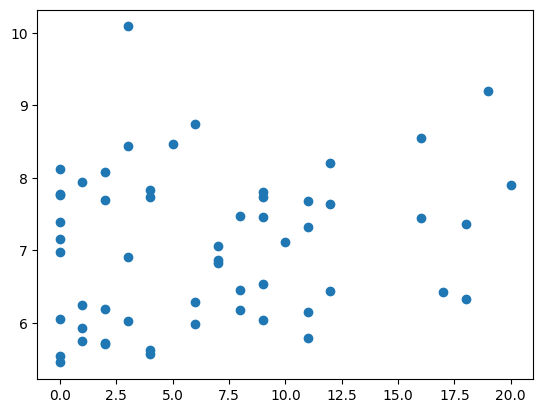

In [158]:
from matplotlib import pyplot as plt

plt.scatter(actual_scores_np, predicted_scores_np)

In [142]:
print(predicted_scores_np)

[7.8920875, 8.18375, 7.126644, 5.875957, 7.2651577, 7.5643306, 5.8904347, 7.83137, 6.8783674, 6.0887055, 5.555094, 8.866116, 5.5561852, 8.257179, 7.4074645, 8.047574, 7.815437, 7.360878, 8.273695, 5.8044252, 5.6372848, 5.6762547, 6.8344703, 6.8140783, 5.7246866, 5.954999, 7.510192, 8.411735, 5.4299664, 8.258038, 7.266088, 6.359288, 5.582153, 5.937116, 7.1894765, 7.514648, 5.1054006, 5.962785, 5.83948, 4.9030437, 5.358515, 6.1850023, 6.847734, 5.964018, 7.8820443, 5.179618, 7.4870267, 10.319972, 7.795944, 7.868913, 7.987097, 6.372832, 5.0716214, 6.1134434, 8.5827875, 6.919725]
